In [1]:
import pandas as pd
import utilities.weather_api as weather

df = pd.read_csv('../datasets/forest_features_20240702.csv')
df

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population,pred_hosp,actual_hosp,is_prediction_over
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528,14.324939,39.0,False
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528,14.324939,47.0,False
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528,38.088067,87.0,False
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528,38.088067,84.0,False
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528,84.159595,138.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44,72,1,3285874,41.556136,52.0,False
1114,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56,72,0,3285874,41.556136,64.0,False
1115,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41,72,0,3285874,42.345551,50.0,False
1116,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61,72,0,3285874,44.852743,48.0,False


Adding a column with the average temperature for the week. This uses past 
forecasts (not the actual recorded temperatures), so we are not incorporating 
future 
information into our prediction model. 

In [6]:
df['avg_temp'] = list(map(weather.get_avg_weekly_forecast_from_loc_code, 
                          [str(code) for code in df['loc_code']], 
                          df['date']))

In [7]:
df

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population,pred_hosp,actual_hosp,is_prediction_over,avg_temp
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528,14.324939,39.0,False,13.183001
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528,14.324939,47.0,False,11.395500
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528,38.088067,87.0,False,8.664249
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528,38.088067,84.0,False,7.251750
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528,84.159595,138.0,False,-0.048250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44,72,1,3285874,41.556136,52.0,False,10.083000
1114,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56,72,0,3285874,41.556136,64.0,False,13.658000
1115,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41,72,0,3285874,42.345551,50.0,False,11.401750
1116,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61,72,0,3285874,44.852743,48.0,False,13.839251


In [8]:
df.to_csv('../datasets/forest_features_20240708.csv', index=False)

We will train 3 different models. Then combine them into an ensemble voting 
model. 

In [34]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df.dropna(inplace=True)

features = ['1_week_roc', 
            'week_of_year', 
            'moving_avg_WIS', 
            'lagged_1wk_WIS',
            'holiday_last_week',
            'avg_temp']
X = df[features]
y = df['is_prediction_over']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       147
           1       0.73      0.53      0.61        66

    accuracy                           0.79       213
   macro avg       0.77      0.72      0.74       213
weighted avg       0.79      0.79      0.78       213



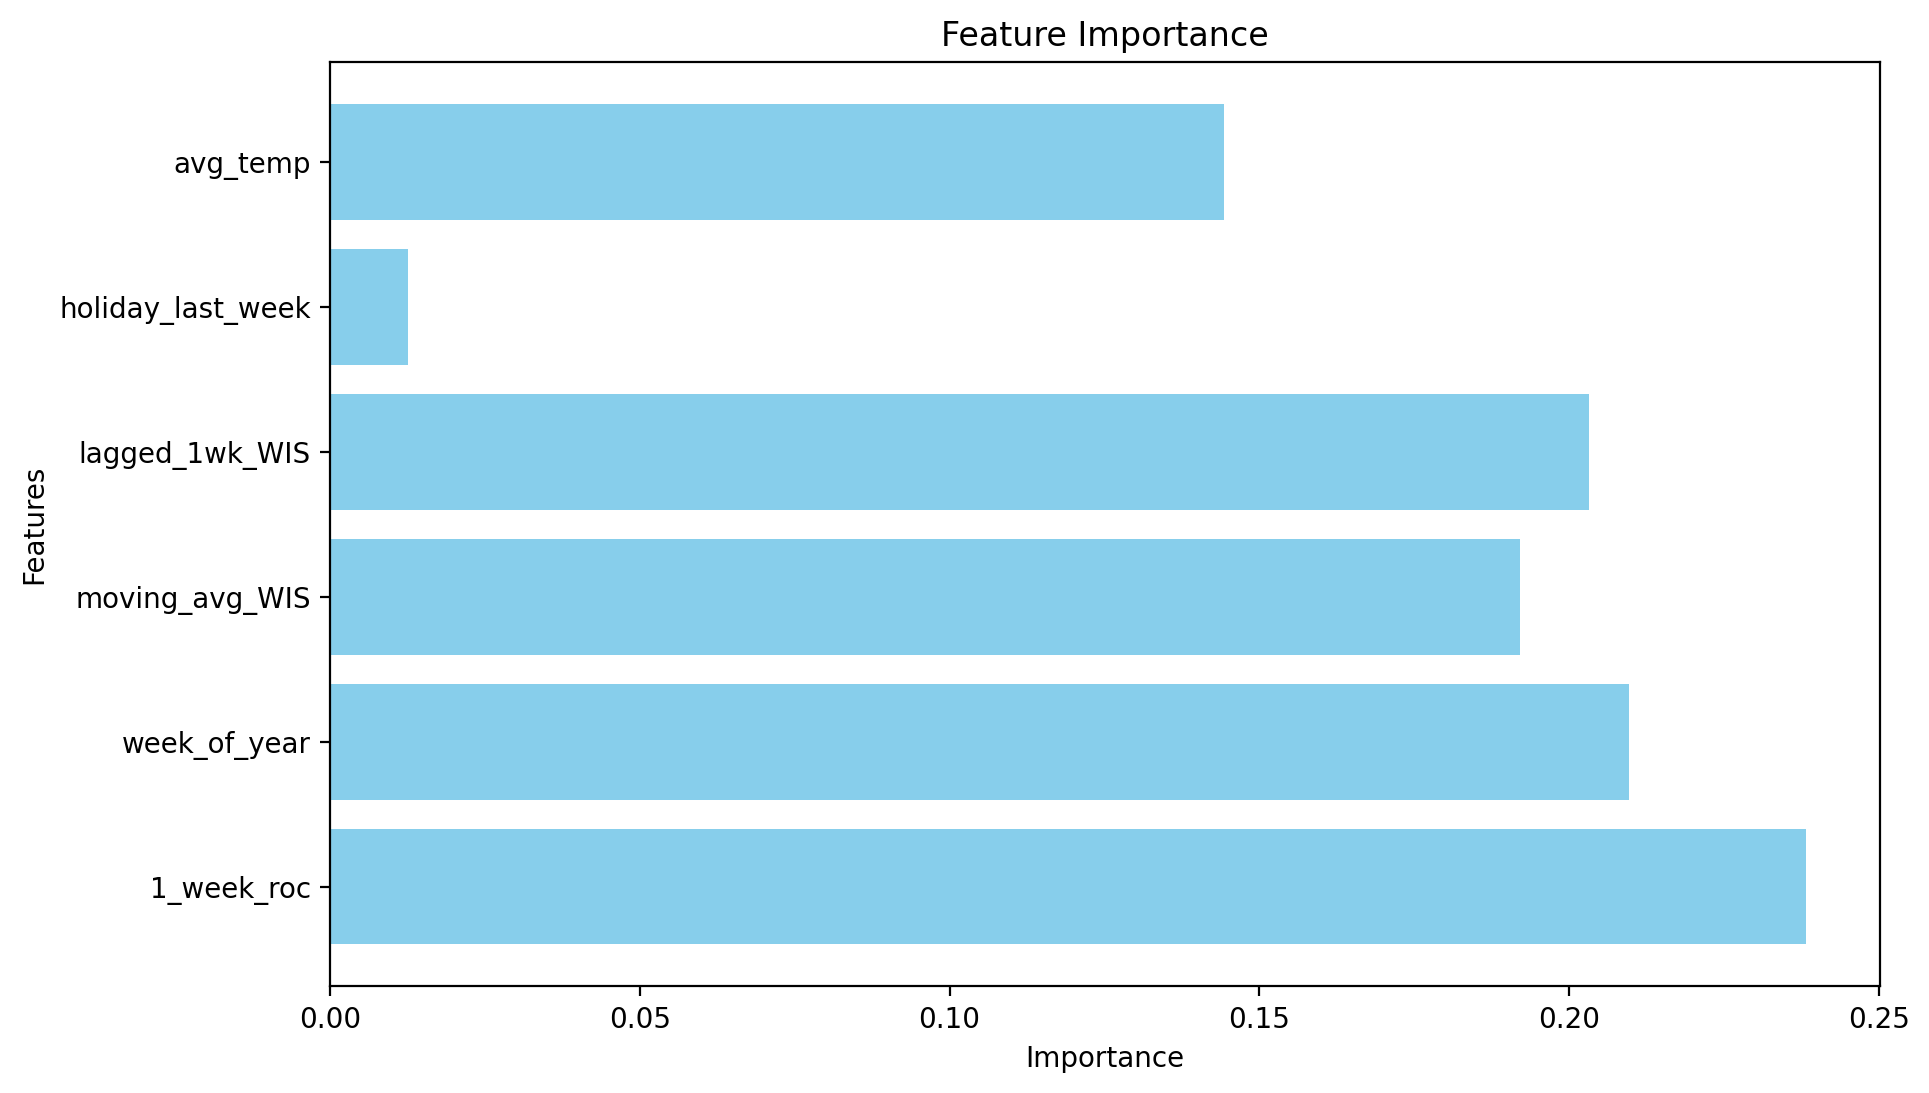

In [19]:
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=200)
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)
svc_model = SVC(probability=True, random_state=42)

# Train models
rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
svc_model.fit(X_train, y_train)

# Voting Classifier
voting_clf_hard = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model), ('svc', svc_model)], voting='hard')
voting_clf_soft = VotingClassifier(estimators=[('rf', rf_model), ('lr', lr_model), ('svc', svc_model)], voting='soft')

# Train Voting Classifier
voting_clf_hard.fit(X_train, y_train)
voting_clf_soft.fit(X_train, y_train)

# Evaluate models
print("Random Forest Classifier")
print(classification_report(y_test, rf_model.predict(X_test)))

print("Logistic Regression Classifier")
print(classification_report(y_test, lr_model.predict(X_test)))

print("SVC Classifier")
print(classification_report(y_test, svc_model.predict(X_test)))

print("Hard Voting Classifier")
print(classification_report(y_test, voting_clf_hard.predict(X_test)))

print("Soft Voting Classifier")
print(classification_report(y_test, voting_clf_soft.predict(X_test)))


Random Forest Classifier
              precision    recall  f1-score   support

       False       0.83      0.93      0.88       145
        True       0.80      0.60      0.69        68

    accuracy                           0.83       213
   macro avg       0.82      0.77      0.78       213
weighted avg       0.82      0.83      0.82       213

Logistic Regression Classifier
              precision    recall  f1-score   support

       False       0.74      0.94      0.83       145
        True       0.71      0.29      0.42        68

    accuracy                           0.74       213
   macro avg       0.73      0.62      0.62       213
weighted avg       0.73      0.74      0.70       213

SVC Classifier
              precision    recall  f1-score   support

       False       0.72      0.94      0.82       145
        True       0.67      0.24      0.35        68

    accuracy                           0.72       213
   macro avg       0.70      0.59      0.58       213
wei

Hmm. This didn't work as well as I wanted it to. We should implement 
different, uncorrelated features for each model, so we don't have the 
correlated error that is liekly present here.